Goal: pairs trading

Author: Julien Granger, 12/01/2022

12/15/22 - This notebook implement regression estimation in matrix form from scratch

In [1]:
import eikon as ek
import configparser as cp
import datetime

import numpy as np
import pandas as pd
from datetime import datetime as dt
%matplotlib inline

pricespath = "C:\\Users\\Julien.Granger\\PycharmProjects\\test\\data\\prices\\"
fundamentals_path = "C:\\Users\\Julien.Granger\\PycharmProjects\\test\\data\\fundamentals\\"

from datetime import date
today = date.today().strftime('%Y-%m-%d')

ImportFromEikon = False

if ImportFromEikon == True:
    try:
        ek.set_app_key('238b7a06c0934497b44933a830b88cd851d71244')
        df1 = ek.get_timeseries('HOc1' ,'close', start_date='2012-01-01', end_date=today, interval = 'daily')
        df2 = ek.get_timeseries('RBc1' ,'close', start_date='2012-01-01', end_date=today, interval = 'daily')
        df3 = ek.get_timeseries('CLc1' ,'close', start_date='2012-01-01', end_date=today, interval = 'daily')
        df1.to_excel(pricespath+"HOc1.xlsx")
        df2.to_excel(pricespath+"RBc1.xlsx")
        df3.to_excel(pricespath+"CLc1.xlsx")
        print("Succesfully connected to Eikon.")
    except Exception:
        print("Can't connect to Eikon.")
        df1 = pd.read_excel(pricespath+"HOc1.xlsx", parse_dates= True)
        df2 = pd.read_excel(pricespath+"RBc1.xlsx", parse_dates= True)
        df3 = pd.read_excel(pricespath+"CLc1.xlsx", parse_dates= True)
        df1.set_index('Date', inplace=True)
        df2.set_index('Date', inplace=True)
        df3.set_index('Date', inplace=True)
else:
    df1 = pd.read_excel(pricespath+"HOc1.xlsx", parse_dates= True)
    df2 = pd.read_excel(pricespath+"RBc1.xlsx", parse_dates= True)
    df3 = pd.read_excel(pricespath+"CLc1.xlsx", parse_dates= True)
    df1.set_index('Date', inplace=True)
    df2.set_index('Date', inplace=True)
    df3.set_index('Date', inplace=True)

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation 
import pandas as pd
import numpy as np

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

In [3]:
# Correct negative number in CL series
df3.loc['2020-04-20'] = 0.5*(df3.loc['2020-04-17'] + df3.loc['2020-04-21'])

<AxesSubplot: xlabel='Date'>

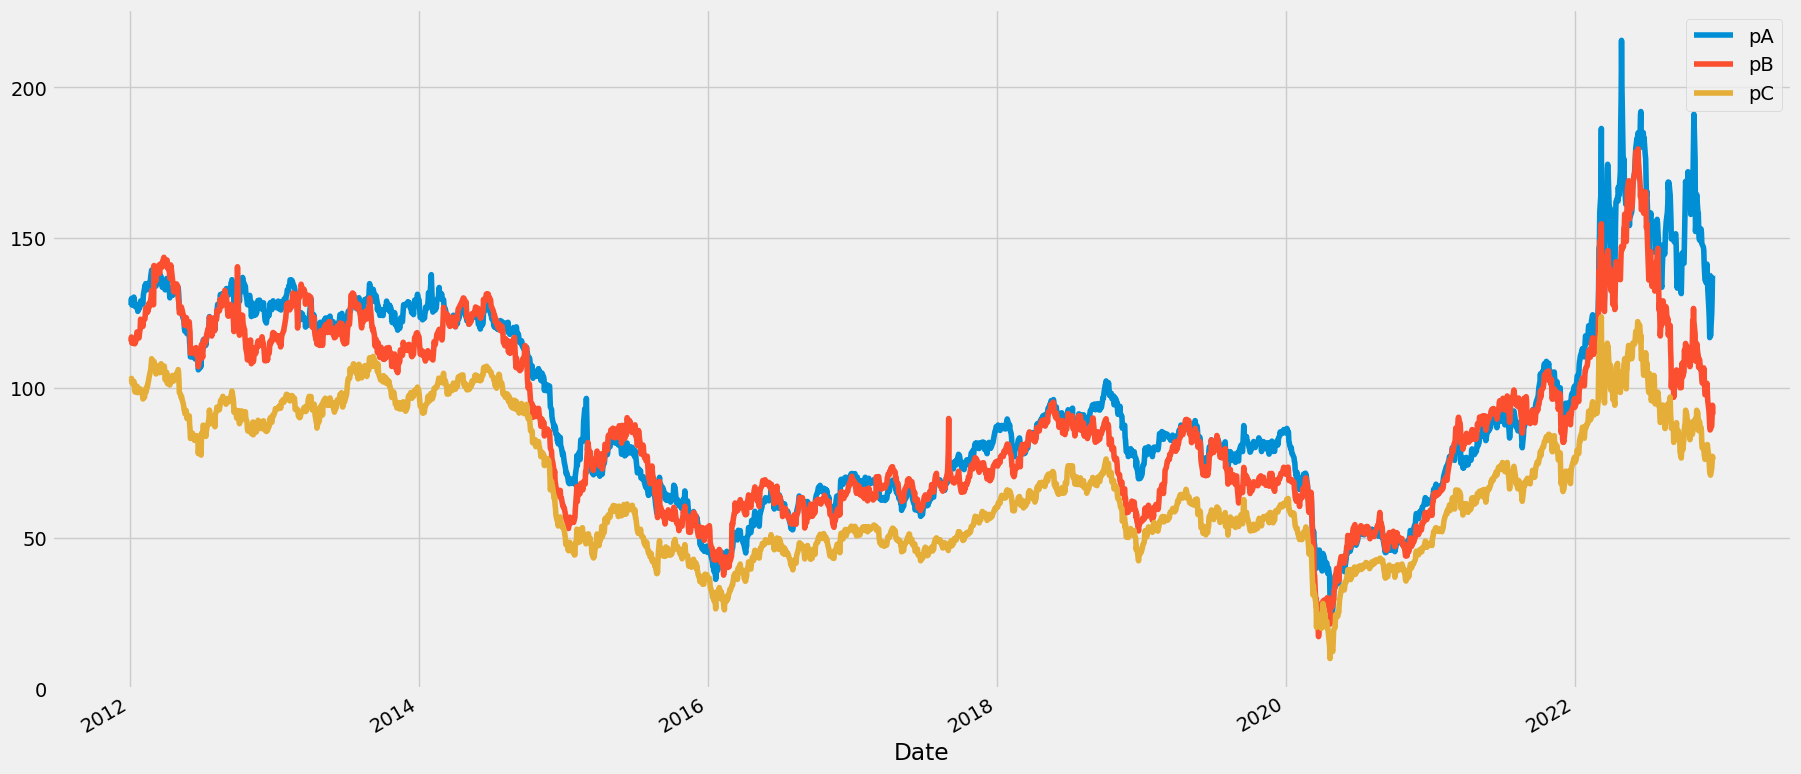

In [4]:
df1.rename(columns={'CLOSE':'pA'}, inplace = True)
df2.rename(columns={'CLOSE':'pB'}, inplace = True)
df3.rename(columns={'CLOSE':'pC'}, inplace = True)
df1 = 42*df1 # HO, RBOB only
df2 = 42*df2 # HO, RBOB only
df = pd.concat([df1, df2, df3],axis=1)
df.astype('float').dtypes
df.plot()

<AxesSubplot: xlabel='Date'>

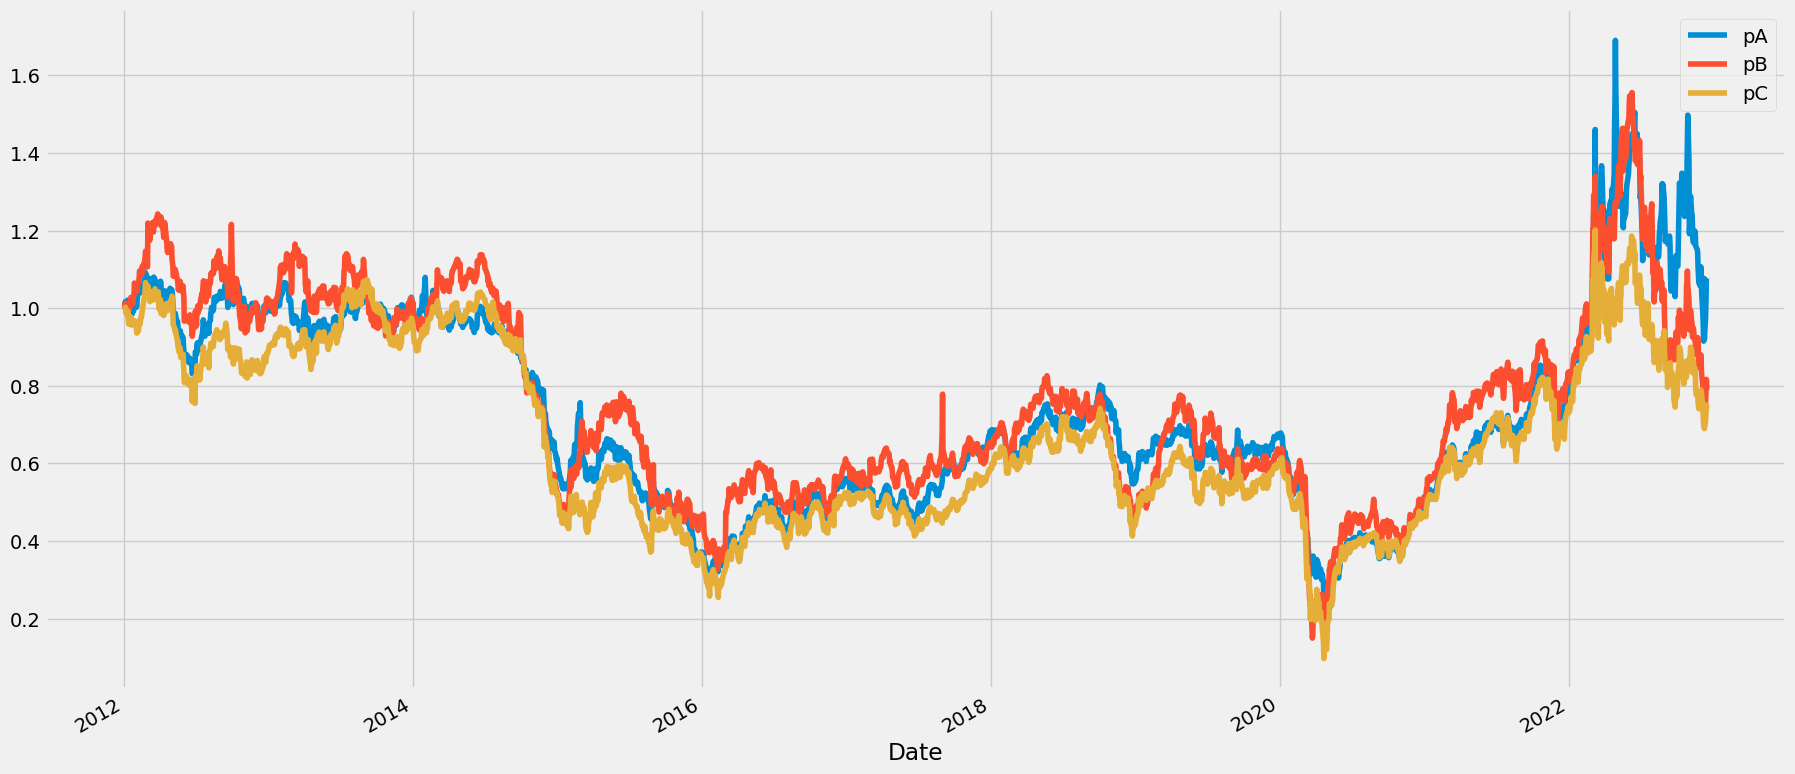

In [5]:
# Cointegration is sensitive to initalize value, normalise to start at one
df = df/df.iloc[0]
df.plot()

<AxesSubplot: xlabel='Date'>

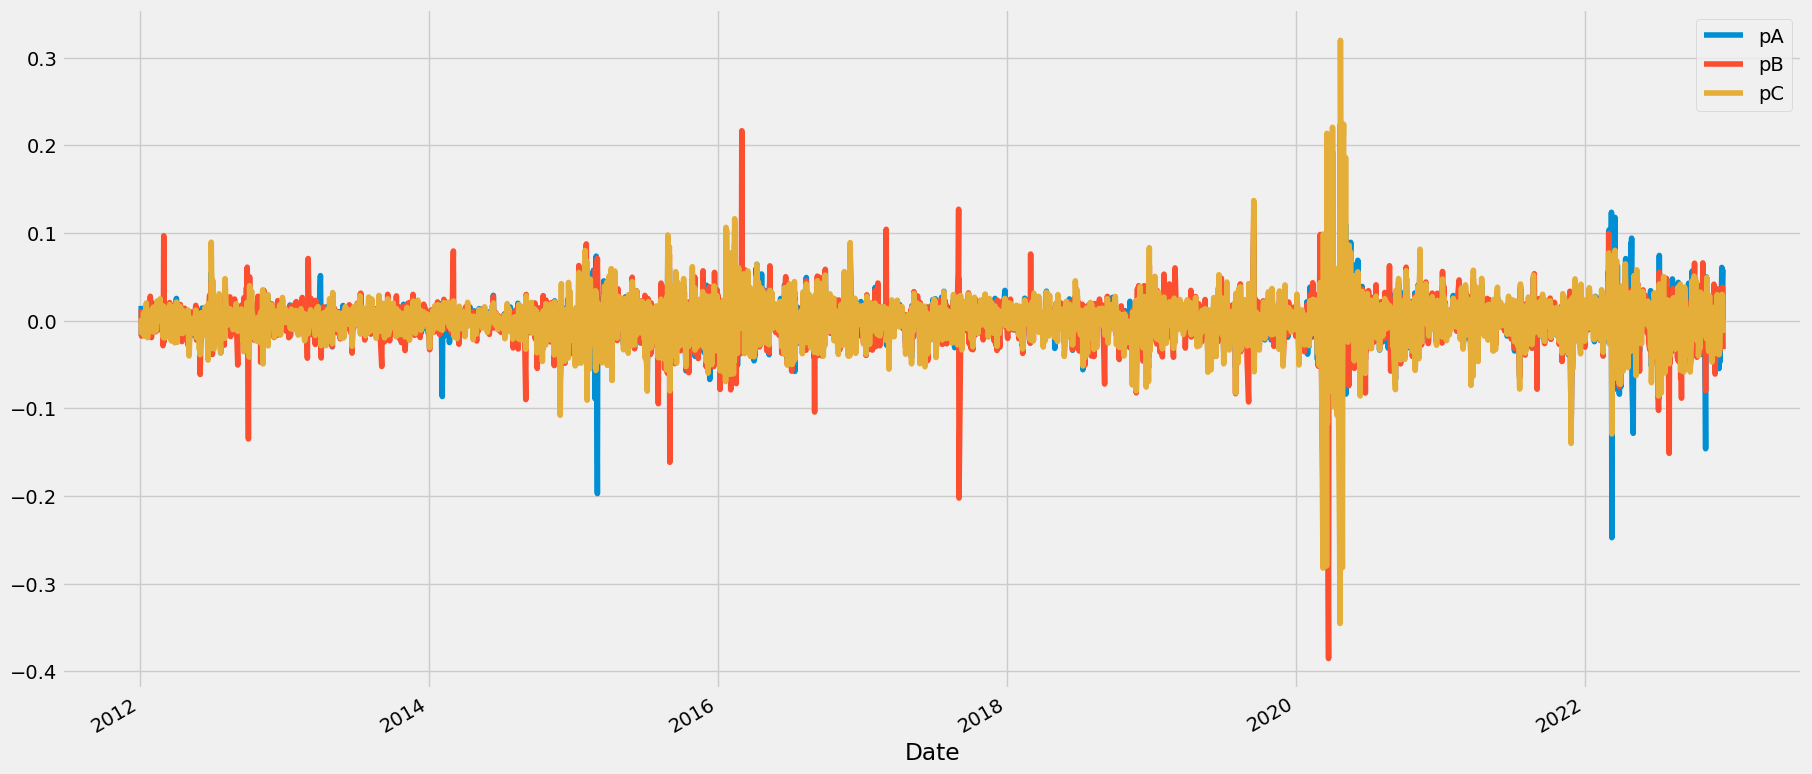

In [6]:
returns  = np.log(df).diff().dropna()
returns.plot()

In [7]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2761 entries, 2012-01-04 to 2022-12-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pA      2761 non-null   float64
 1   pB      2761 non-null   float64
 2   pC      2761 non-null   float64
dtypes: float64(3)
memory usage: 86.3 KB


In [8]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR(returns.astype(float))
results = model.fit(maxlags=4, ic='aic')
results.summary()

c:\users\julien.granger\pycharmprojects\test1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Jan, 2023
Time:                     12:51:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.2901
Nobs:                     2757.00    HQIC:                  -23.3436
Log likelihood:           20523.8    FPE:                7.06086e-11
AIC:                     -23.3739    Det(Omega_mle):     6.96191e-11
--------------------------------------------------------------------
Results for equation pA
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000032         0.000435            0.074           0.941
L1.pA         0.028358         0.029554            0.960           0.337
L1.pB        -0.032120         0.022595           -1.422           0.155
L1.pC         0.021394

In [9]:
import MyOLS as MyOLS

In [10]:
def VAR_model(ret, lags):
    import numpy as np
    from numpy import linalg
    import MyOLS as MyOLS
    
    # Extract column names
    features = ret.columns
    
    ret2 = ret.copy()
    
    #--------------------------------------
    # Make matrix of explanatory variables
    #--------------------------------------
    # Loop through each lags
    for i in range(1, lags + 1):
        # Loop through each features
        for j in features:        
            # Add lag i of feature j to the dataframe
            ret2[f"{j}_Lag_{i}"] = ret[j].shift(i)
    ret2.dropna(inplace = True)
    X = ret2.drop(columns = features)
    
    # Insert an intercept column 
    X.insert(0, "Intercept", 1)
    
    #--------------------------------------
    # Make matrix of dependent variables
    #--------------------------------------
    Y = ret2[features]
    
    # Store results
    Results = dict()    
    Results['X'] = X 
    Results['Y'] = Y
    
    # Do linear regression
    mymodel = MyOLS.MyOLS(Y,X)
    LR_results = mymodel.fit()
    
    # For stability check, need to write the companion form and check eigenvalues
    Psi = pd.DataFrame(LR_results['B_hat'].T)
    # drop first column
    Psi = Psi.iloc[: , 1:]  
    # reset column numbers
    Psi.columns = range(Psi.columns.size)
    
    dim = len(features)*(lags-1)
    Identity = np.eye(dim)
    Zeroes = np.zeros((dim, len(features)))
    IdentityZeroes = np.concatenate([Identity, Zeroes], axis = 1)
    Psi = pd.concat([Psi, pd.DataFrame(IdentityZeroes)], axis = 0)
    #print(Psi.head(len(Psi)))
    
    # Get eigenvalues
    try:
        eig = linalg.eigvals(Psi)
    except np.linalg.LinAlgError:
        print("Can't compute eigenvalues.")
    
    # Stable if absolute value less then 1
    #print(pd.DataFrame(eig))
    #print(np.abs(pd.DataFrame(eig)))
    isStable = False
    isStable = (np.abs(pd.DataFrame(eig))<1).eq(True).all()
    #print(isStable)
    
    
    
    # Store results    
    Results['LR'] = LR_results 
    Results['VAR_stable'] = isStable
    
    
    return Results    

In [11]:
returns0  = np.log(df).diff().dropna()
Res0 = VAR_model(returns0.astype(float), 3)
Res0['LR']['df'].head(20)

Estimate                     SD of Estimate                      \
                 pA        pB        pC             pA        pB        pC   
Intercept  0.000028 -0.000075 -0.000131       0.000435  0.000529  0.000540   
pA_Lag_1   0.026521 -0.022645 -0.023242       0.029467  0.035769  0.036545   
pB_Lag_1  -0.030196 -0.043044 -0.088225       0.022324  0.027098  0.027686   
pC_Lag_1   0.018258  0.047329  0.069052       0.024173  0.029342  0.029978   
pA_Lag_2  -0.033746 -0.015940  0.081180       0.029405  0.035693  0.036468   
pB_Lag_2   0.036411  0.011492  0.102560       0.022330  0.027105  0.027693   
pC_Lag_2  -0.005019 -0.020146 -0.168632       0.023886  0.028994  0.029624   
pA_Lag_3  -0.040485 -0.066235  0.088097       0.029477  0.035781  0.036558   
pB_Lag_3  -0.033277 -0.058368 -0.016659       0.022420  0.027214  0.027804   
pC_Lag_3   0.047122  0.130458 -0.139844       0.024114  0.029270  0.029906   

          t-Statistic                      
                   pA        pB        pC  
Intercept    0.063890 -0.141787 -0.242696  
pA_Lag_1     0.899993 -0.633094 -0.635977  
pB_Lag_1    -1.352637 -1.588466 -3.186656  
pC_Lag_1     0.755303  1.613050  2.303391  
pA_Lag_2    -1.147611 -0.446588  2.226072  
pB_Lag_2     1.630567  0.423988  3.703399  
pC_Lag_2    -0.210129 -0.694821 -5.692495  
pA_Lag_3    -1.373437 -1.851130  2.409809  
pB_Lag_3    -1.484300 -2.144810 -0.599141  
pC_Lag_3     1.954125  4.456982 -4.676162

Observation: we have the same results as above.

In [12]:
BIC = pd.DataFrame([VAR_model(returns0.astype(float), p+1)['LR']['BIC'] for p in range(10)], index=[p+1 for p in range(10)])
BIC

,0
1,-23.266000
2,-23.297633
3,-23.361005
4,-23.390668
5,-23.411037
6,-23.439247
7,-23.444347
8,-23.451945
9,-23.460261
10,-23.482384


In [13]:
BIC.idxmin()

0    10
dtype: int64

In [14]:
AIC = pd.DataFrame([VAR_model(returns0.astype(float), p+1)['LR']['AIC'] for p in range(10)], index=[p+1 for p in range(10)])
AIC

,0
1,-23.274584
2,-23.306220
3,-23.369594
4,-23.399260
5,-23.419632
6,-23.447844
7,-23.452947
8,-23.460547
9,-23.468866
10,-23.490992


In [15]:
AIC.idxmin()

0    10
dtype: int64

## Can I quickly do ADF test in matrix form?

In [16]:
import MyLR

In [17]:
returns0.head()

,pA,pB,pC
Date,,,
2012-01-04,0.016873,0.013228,0.002522
2012-01-05,-0.016676,-0.017640,-0.013754
2012-01-06,0.010280,0.005503,-0.002459
2012-01-09,0.000912,0.002686,-0.002465
2012-01-10,0.009199,0.004989,0.009138


In [18]:
Res1 = VAR_model(returns0.astype(float), 1)
Res1['LR']['df'].head(20)

Estimate                     SD of Estimate                      \
                 pA        pB        pC             pA        pB        pC   
Intercept  0.000020 -0.000090 -0.000108       0.000436  0.000530  0.000547   
pA_Lag_1   0.031208 -0.010110 -0.031272       0.029301  0.035643  0.036737   
pB_Lag_1  -0.026203 -0.035996 -0.089887       0.022301  0.027128  0.027961   
pC_Lag_1   0.008037  0.026066  0.075766       0.023743  0.028882  0.029768   

          t-Statistic                      
                   pA        pB        pC  
Intercept    0.045166 -0.169103 -0.197382  
pA_Lag_1     1.065099 -0.283640 -0.851241  
pB_Lag_1    -1.174967 -1.326874 -3.214727  
pC_Lag_1     0.338493  0.902491  2.545216

In [19]:
retPA = pd.DataFrame(returns0['pA'])
retPA.columns= ['pA']
retPA.head()

,pA
Date,
2012-01-04,0.016873
2012-01-05,-0.016676
2012-01-06,0.010280
2012-01-09,0.000912
2012-01-10,0.009199


In [20]:
Res2 = VAR_model(retPA.astype(float), 1)
Res2['LR']['df'].head(20)

,Estimate,SD of Estimate,t-Statistic
,pA,pA,pA
Intercept,0.000021,0.000436,0.048501
pA_Lag_1,0.017699,0.019037,0.929734


In [21]:
def ADF_model(levels, lags):
    # Extract column names
    features = levels.columns    
    levels2 = levels.copy()
    
    # Add 1-lag 
    for j in features:
        levels[f"{j}_Lag_1"] = levels[j].shift(1)
    
    # make the auto-regressive terms
    for i in range(1, lags + 1):
        # Loop through each features
        for j in features:        
            # Add lag i of feature j to the dataframe
            levels[f"{j}_Diff_{i}"] = levels[j].diff(i)
    levels.dropna(inplace = True) 
    
    # Drop today's level
    X = levels.drop(columns = features)
    
    # Insert an intercept column 
    #X.insert(0, "Intercept", 1)    
    
    #--------------------------------------
    # Make matrix of dependent variables
    #--------------------------------------
    for i in range(2):
        # Loop through each features
        for j in features:
            target = f"{j}_Diff_{i}"
    
    Y = pd.DataFrame(levels[target])    
    X.drop(columns = target, inplace = True)
    print(X.head())
    print(Y.head())
    
    # Store results
    Results = dict()    
    Results['X'] = X 
    Results['Y'] = Y
    
    # Do linear regression
    mymodel = MyOLS.MyOLS(Y,X)
    LR_results = mymodel.fit()
    
    # Store results    
    Results['LR'] = LR_results 
    
    return Results

In [22]:
Res2 = ADF_model(pd.DataFrame(df['pA']), 3)
Res2['LR']['df'].head(20)

            pA_Lag_1  pA_Diff_2  pA_Diff_3
Date                                      
2012-01-06  1.000197  -0.006484   0.010533
2012-01-09  1.010533   0.011257  -0.005563
2012-01-10  1.011454   0.010269   0.020604
2012-01-11  1.020802  -0.002765  -0.001843
2012-01-12  1.008689  -0.015568  -0.006221
            pA_Diff_1
Date                 
2012-01-06   0.010335
2012-01-09   0.000922
2012-01-10   0.009348
2012-01-11  -0.012112
2012-01-12  -0.003456


,Estimate,SD of Estimate,t-Statistic
,pA_Diff_1,pA_Diff_1,pA_Diff_1
pA_Lag_1,-0.000258,0.000307,-0.840098
pA_Diff_2,0.565063,0.015727,35.929995
pA_Diff_3,-0.064169,0.012882,-4.981400


In [23]:
from statsmodels.tsa.stattools import adfuller
adfuller(df.pA, 1, regression = "n")

(-0.5999866808123638,
 0.45463213484178955,
 1,
 2760,
 {'1%': -2.5665505485979834,
  '5%': -1.9410977590956888,
  '10%': -1.6167241231897376},
 -14239.19488206603)

In [24]:
df.pA.head()

Date
2012-01-03    1.000000
2012-01-04    1.017017
2012-01-05    1.000197
2012-01-06    1.010533
2012-01-09    1.011454
Name: pA, dtype: float64

In [25]:
adfuller(df.pA, 1, regression = "n")[0]

-0.5999866808123638

In [26]:
T = 2760
-1.941-0.2686*T**(-1)-3.365*T**(-2)+31.223*T**(-3)

-1.9410977590956888

In [27]:
-2.86154-2.8903*T**(-1)-4.234*T**(-2)+40.040*T**(-3)

-2.862587764058595